In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os
# Create a MirroredStrateg, If Multi-GPU available
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' 
tf.config.set_soft_device_placement(True)
# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2']) 
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from livelossplot.keras import PlotLossesCallback
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tqdm import tqdm
import efficientnet.keras as efn
import h5py, glob, re, cv2, math, matplotlib, pickle, gc
import tensorflow.keras as keras
import pandas as pd
from pandas import read_csv
import numpy as np
from scipy import stats
import itertools, random
from collections import Counter
# from cnn_utils import *
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from PIL import Image  
import pdb
from statistics import mode 
from IPython.display import clear_output

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

np.random.seed(1)
# Setting the seed for python random numbers
random.seed(1254)
# Setting the graph-level random seed.
tf.random.set_seed(89)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
!CUDA_VISIBLE_DEVICES=2

# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2'])
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# def setup_multi_node_training(): # IMPORTANT: SET UP TF_CONFIG FOR MULTINODE TRAINING HERE os.environ[“TF_FORCE_GPU_ALLOW_GROWTH”] = “true” tf.config.set_soft_device_placement(True) mirrored_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(tf.distribute.experimental.CollectiveCommunication.NCCL) # Constructs the configuration run_config = tf.estimator.RunConfig( train_distribute=mirrored_strategy, ) return run_config
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Using TensorFlow backend.


Num GPUs Available:  1


## Load data

In [2]:
# filename = 'Datasets/final_imit_spec.pkl'
# filename = 'Datasets/final_imit_spec2_128.pkl'
filename = 'Datasets/final_imit_spec2_128_last.pkl'
with open(filename, 'rb') as input:
    x = pickle.load(input)
imit_train_images, imit_test_images, imit_y_train, imit_y_test, imit_env_train, imit_env_test = [x[0], x[1]
                                                                                                , x[2], x[3]
                                                                                                , x[4], x[5]]
print(imit_train_images.shape)
print(imit_test_images.shape)
print(imit_y_train.shape)
print(imit_y_test.shape)
print(imit_env_train.shape)
print(imit_env_test.shape)

(800, 120, 128, 128, 3)
(200, 120, 128, 128, 3)
(800, 120, 19)
(200, 120, 19)
(800,)
(200,)


In [3]:
# filename = 'Datasets/final_native_spec.pkl'
# with open(filename, 'rb') as input:
#     x = pickle.load(input)
# native_train_images, native_test_images, native_y_train, native_y_test, native_env_train, native_env_test = [x[0], x[1]
#                                                                                                 , x[2], x[3]
#                                                                                                 , x[4], x[5]]
# print(len(native_train_images))
# print(len(native_test_images))
# print(native_y_train.shape)
# print(native_y_test.shape)
# print(native_env_train.shape)
# print(native_env_test.shape)

##### STA LTA

In [4]:
def sta_lta2(vec,nlta,nsta,init_th,stop_th,stepsz):
    vec2 = np.zeros(vec.shape)
    mask = np.zeros(vec.shape)
    state = 0 # '0' nothing, '1' signing
    
    for i in range(0,len(vec),stepsz):
        
        if i+nlta+nsta+1 > len(vec):
            if state == 1:
                stoppt = len(vec)-2
                vec2[startpt:stoppt] = vec[startpt:stoppt]
                mask[startpt:stoppt] = 1
            break
            
            
        longwin = vec[i:i+nlta]
        shortwin = vec[i+nlta:i+nlta+nsta]
        
        if i < nlta and np.mean(longwin) > 150:
            vec2[0:i+nsta] = vec[0:i+nsta]
            mask[0:i+nsta] = 1
        if init_th < sum(shortwin)/sum(longwin):
            if state == 0:
                startpt = i+nlta
                state = 1
            if state == 1:
                continue
        
        else:
            if state == 0:
                continue
            if state == 1:
                if sum(shortwin)/sum(longwin) > stop_th:
                    continue
                else:
                    stoppt = i+nlta+int(nsta/2)
                    state = 0
                    vec2[startpt:stoppt] = vec[startpt:stoppt]
                    mask[startpt:stoppt] = 1
                    
    return vec2, mask

In [190]:
duration = 24.2
nsta_sec = 0.7
ratio = imit_env_train[0].shape[-1]/duration
nsta = int(nsta_sec*ratio)
nlta = int(2*nsta)
stepsz = int(0.2*ratio) # 0.2
timevec = np.linspace(0,24.2,imit_env_train[0].shape[-1])
idx = 27
init_th = 0.6
stop_th = 0.3
vecs_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
mask_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
vecs_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
mask_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
for i in range(len(imit_env_train)):
    vecs_train.append(sta_lta2(imit_env_train[i],nlta,nsta,init_th,stop_th,stepsz)[0])
    mask_train.append(sta_lta2(imit_env_train[i],nlta,nsta,init_th,stop_th,stepsz)[1])
# mask_train_win = mask_train[:,::5]
for i in range(len(imit_env_test)):
    vecs_test.append(sta_lta2(imit_env_test[i],nlta,nsta,init_th,stop_th,stepsz)[0])
    mask_test.append(sta_lta2(imit_env_test[i],nlta,nsta,init_th,stop_th,stepsz)[1])
# mask_test_win = mask_test[:,::5]
mask_train = np.array(mask_train)
mask_test = np.array(mask_test)

# ideal masks

In [48]:
mask_tr_ideal = np.array([y!=0 for y in np.argmax(imit_y_train,-1)])
print(mask_tr_ideal.shape)
mask_ts_ideal = np.array([y!=0 for y in np.argmax(imit_y_test,-1)])
print(mask_ts_ideal.shape)

(800, 120)
(200, 120)


### Visualize

Text(0, 0.5, 'Normalized Euclidean Distance')

/home/m/.local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Comic Sans MS'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


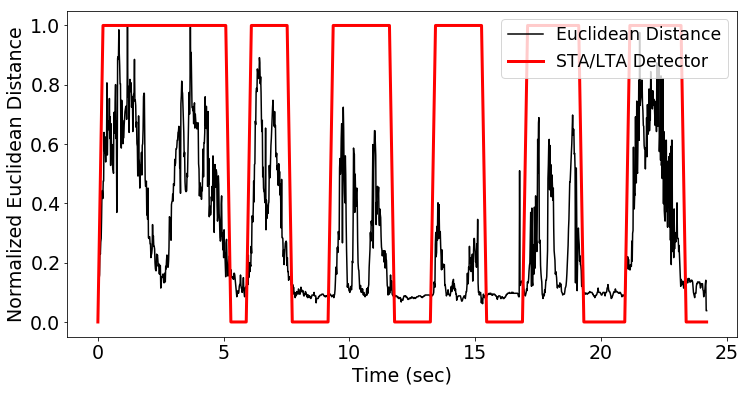

In [51]:
idx = 3
plt.plot(timevec,imit_env_test[idx]/max(imit_env_test[idx]),color='black')
timevec2 = np.linspace(0,np.max(timevec),len(mask_ts_ideal[0]))
plt.plot(timevec2,mask_ts_ideal[idx],linewidth=3,color='red')
plt.legend(['Euclidean Distance','STA/LTA Detector'], loc = 'upper right', fontsize = 'xx-large')
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlabel('Time (sec)',fontsize=19, fontname='Comic Sans MS')
plt.ylabel('Normalized Euclidean Distance',fontsize=19)
# plt.savefig(str(idx)+' gesture detect.png',dpi=400)

In [191]:
def gesture_counter(mask):
    cnt = 0
    flag = 0
    for i in range(len(mask)):
        if flag == 0 and mask[i] == 0:
            continue
        if flag == 1 and mask[i] == 1:
            continue
        if flag == 0 and mask[i] == 1:
            flag = 1
            cnt += 1
        if flag == 1 and mask[i] == 0:
            flag = 0
    return cnt

In [192]:
numgest = [gesture_counter(m) for m in mask_test]
sum(numgest)

1291

In [49]:
numgest = [gesture_counter(m) for m in mask_ts_ideal]
sum(numgest)

1114

In [9]:
num_class = 19

In [10]:
def masker(x, y, mask):
    x2 = []
    y2 = []
    flag = 0
    for i in range(len(mask)):
        for j in range(mask.shape[1]):
            if flag == 0 and mask[i,j] == 0:
                continue
            if flag == 1 and mask[i,j] == 1:
                if j == mask.shape[1]-1 and j+1 - startpt > 2:
                    stoppt = j+1
                    x2.append(x[i,startpt:stoppt])
                    y2.append(y[i,startpt:stoppt])
                else:
                    continue
            if flag == 0 and mask[i,j] == 1:
                flag = 1
                startpt = j
            if flag == 1 and mask[i,j] == 0:
                flag = 0
                stoppt = j+1
                if stoppt-startpt > 2:
                    x2.append(x[i,startpt:stoppt])
                    y2.append(y[i,startpt:stoppt])
    
    x2 = np.asarray(x2)
    y2 = np.array([to_categorical(y,num_classes=num_class) for y in np.array(y2)])
    return x2, y2

In [11]:
def down_mask(mask, des_len):
    return np.array([mask[int(len(mask)/des_len*i)] for i in range(des_len)])

In [193]:
des_len = imit_train_images.shape[1]
mask_down_train = np.array([down_mask(mask, des_len) for mask in mask_train])
mask_down_test = np.array([down_mask(mask, des_len) for mask in mask_test])
# mask_down_train = mask_tr_ideal
# mask_down_test = mask_ts_ideal
y_down_train = np.array([down_mask(y, des_len) for y in imit_y_train])
y_down_test = np.array([down_mask(y, des_len) for y in imit_y_test])
y_down_train_cat = to_categorical(y_down_train, num_classes=num_class)
y_down_test_cat = to_categorical(y_down_test, num_classes=num_class)
print(mask_down_train.shape)
print(mask_down_test.shape)
print(y_down_train.shape)
print(y_down_test.shape)
print(y_down_train_cat.shape)
print(y_down_test_cat.shape)

(800, 120)
(200, 120)
(800, 120, 19)
(200, 120, 19)
(800, 120, 19, 19)
(200, 120, 19, 19)


In [194]:
x3train, y3train = masker(imit_train_images, np.argmax(y_down_train,-1), mask_down_train)
x3test, y3test = masker(imit_test_images, np.argmax(y_down_test,-1), mask_down_test) 
print(x3train.shape)
print(y3train.shape)
print(x3test.shape)
print(y3test.shape)

(4735,)
(4735,)
(1190,)
(1190,)


In [66]:
y3train[0].shape

(43, 19)

In [67]:
classes = [stats.mode(np.argmax(y,-1))[0] for y in y3train]
c = [int(x) for x in classes]
Counter(c)

Counter({1: 797,
         10: 161,
         11: 162,
         12: 162,
         3: 800,
         2: 464,
         4: 163,
         5: 168,
         6: 168,
         16: 162,
         17: 166,
         18: 166,
         7: 153,
         8: 156,
         9: 156,
         13: 146,
         14: 148,
         15: 147})

In [68]:
# eliminate zeros md
x6train = np.array([x3train[i] for i in range(len(y3train)) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
y6train = np.array([y3train[i] for i in range(len(y3train)) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
x6test = np.array([x3test[i] for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
y6test = np.array([y3test[i] for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
print(x6train.shape)
print(y6train.shape)
print(x6test.shape)
print(y6test.shape)

(4445,)
(4445,)
(1114,)
(1114,)


## RD - RA

In [17]:
# filename = 'Datasets/final_imit_RD-RA2.pkl'
# with open(filename, 'rb') as input:
#     x = pickle.load(input)
# imit_y_train_RD, imit_y_test_RD, imit_RD_train, imit_RA_train, imit_RD_test, imit_RA_test = [x[0], x[1]
#                                                                                                 , x[2], x[3]
#                                                                                                 , x[4], x[5]]
# print(imit_y_train_RD.shape)
# print(imit_y_test_RD.shape)
# print(imit_RD_train.shape)
# print(imit_RA_train.shape)
# print(imit_RD_test.shape)
# print(imit_RA_test.shape)
# del x

In [18]:
filename = 'Datasets/final_imit_RD-RA2_128_last.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
imit_RD_train = np.array(data["train_RD"])
imit_RA_train = np.array(data["train_RA"])
imit_RD_test = np.array(data["test_RD"])
imit_RA_test = np.array(data["test_RA"])
data.close()
print(imit_RD_train.shape)
print(imit_RA_train.shape)
print(imit_RD_test.shape)
print(imit_RA_test.shape)

Selected File: Datasets/final_imit_RD-RA2_128_last.hdf5
(800, 605, 128, 128, 3)
(800, 605, 128, 128, 3)
(200, 605, 128, 128, 3)
(200, 605, 128, 128, 3)


In [19]:
# windowed RD
interval = range(0,600)
x_train11 = np.reshape(imit_RD_train[:,interval,:,:,:], (imit_RD_train.shape[0],120,5,imit_RD_train.shape[2],imit_RD_train.shape[3],imit_RD_train.shape[4]))
x_test11 = np.reshape(imit_RD_test[:,interval,:,:,:], (imit_RD_test.shape[0],120,5,imit_RD_test.shape[2],imit_RD_test.shape[3],imit_RD_test.shape[4]))
# y_train11 = np.reshape(imit_y_train_RD[:,interval], (imit_y_train_RD.shape[0],120,5))
# y_test11 = np.reshape(imit_y_test_RD[:,interval], (imit_y_test_RD.shape[0],120,5))
# y_train11 = to_categorical(np.squeeze(stats.mode(y_train11,2)[0]))
# y_test11 = to_categorical(np.squeeze(stats.mode(y_test11,2)[0]))
print(x_train11.shape)
# print(y_train11.shape)
print(x_test11.shape)
# print(y_test11.shape)  

# windowed RA
x_train12 = np.reshape(imit_RA_train[:,interval,:,:,:], (imit_RA_train.shape[0],120,5,imit_RA_train.shape[2],imit_RA_train.shape[3],imit_RA_train.shape[4]))
x_test12 = np.reshape(imit_RA_test[:,interval,:,:,:], (imit_RA_test.shape[0],120,5,imit_RA_test.shape[2],imit_RA_test.shape[3],imit_RA_test.shape[4]))
print(x_train12.shape)
print(x_test12.shape)

(800, 120, 5, 128, 128, 3)
(200, 120, 5, 128, 128, 3)
(800, 120, 5, 128, 128, 3)
(200, 120, 5, 128, 128, 3)


In [76]:
# x1train, y1train = masker(x_train11, np.argmax(y_train11,-1), mask_down_train)
# x1test, y1test = masker(x_test11, np.argmax(y_test11,-1), mask_down_test)
# x2train, y1train = masker(x_train12, np.argmax(y_train11,-1), mask_down_train)
# x2test, y1test = masker(x_test12, np.argmax(y_test11,-1), mask_down_test)
x1train, y1train = masker(x_train11, y_down_train, mask_down_train)
x1test, y1test = masker(x_test11, y_down_test, mask_down_test)
x2train, y1train = masker(x_train12, y_down_train, mask_down_train)
x2test, y1test = masker(x_test12, y_down_test, mask_down_test)
print(x1train.shape)
print(y1train.shape)
print(x1test.shape)
print(y1test.shape)
print(x2train.shape)
print(x2test.shape)

(4445,)
(4445,)
(1114,)
(1114,)
(4445,)
(1114,)


In [77]:
x10train = np.array([x1train[i] for i in range(len(y3train)) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
x11train = np.array([x2train[i] for i in range(len(y3train)) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
# y10train = np.array([y1train[i] for i in range(len(y3train)) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
x10test = np.array([x1test[i] for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
x11test = np.array([x2test[i] for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
# y10test = np.array([y1test[i] for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
print(x10train.shape)
# print(y10train.shape)
print(x10test.shape)
# print(y10test.shape)
print(x11train.shape)
print(x11test.shape)

(4445,)
(1114,)
(4445,)
(1114,)


In [78]:
x12train = np.array([x.reshape(x.shape[0]*x.shape[1],x.shape[2],x.shape[3],x.shape[4]) for x in x10train])
x13train = np.array([x.reshape(x.shape[0]*x.shape[1],x.shape[2],x.shape[3],x.shape[4]) for x in x11train])
x12test = np.array([x.reshape(x.shape[0]*x.shape[1],x.shape[2],x.shape[3],x.shape[4]) for x in x10test])
x13test = np.array([x.reshape(x.shape[0]*x.shape[1],x.shape[2],x.shape[3],x.shape[4]) for x in x11test])
print(x12train[0].shape)
print(x12test[0].shape)
print(x13train.shape)
print(x13test.shape)

(215, 128, 128, 3)
(155, 128, 128, 3)
(4445,)
(1114,)


In [23]:
input_shape_vid = (None, x_train11[0].shape[1],x_train11[0].shape[2],x_train11[0].shape[3],x_train11[0].shape[4])
print('Input shape of f-b-f RD: ',input_shape_vid)

Input shape of f-b-f RD:  (None, 5, 128, 128, 3)


In [24]:
input_shape11 = (None,x3train[0].shape[1],x3train[0].shape[2],x3train[0].shape[3])
print('Input shape of f-b-f mD: ',input_shape11)

Input shape of f-b-f mD:  (None, 128, 128, 3)


In [25]:
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=early_stopping_patience, restore_best_weights=True
)

In [26]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.5, patience=0, verbose=0)

In [27]:
gc.collect()

149

In [28]:
ytrain = np.array([np.squeeze(to_categorical(stats.mode(np.argmax(y3train[i],-1))[0],19)) for i in tqdm(range(len(y3train)), position = 0, leave = True) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
ytest = np.array([np.squeeze(to_categorical(stats.mode(np.argmax(y3test[i],-1))[0],19)) for i in tqdm(range(len(y3test)), position = 0, leave = True) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
print(ytrain.shape)
print(ytest.shape)

100%|██████████| 1190/1190 [00:00<00:00, 2745.61it/s]

(4643, 19)
(1164, 19)


In [29]:
def mode_finder(y): # finds the mode that is not zero
    y = np.argmax(y,-1)
    mode = stats.mode(y)[0]
    if mode == 0:
        mask = y == mode
        y = y[~np.ma.masked_array(y, mask = mask).mask]
        new_mode = stats.mode(y)[0]
    else:
        new_mode = mode
    return np.squeeze(new_mode)

# Gesture detector accuracy

In [30]:
print(mask_down_train.shape)
mask_y = np.argmax(y_down_train,-1) == 0
print(mask_y.shape)
cmp = mask_y != mask_down_train
print(cmp.shape)
acc = np.sum(cmp)/(cmp.shape[0]*cmp.shape[1])*100
print(acc)

(800, 120)
(800, 120)
(800, 120)
83.53125


### Fusion

In [69]:
y_int_train = np.array([np.argmax(y,-1) for y in y6train])
y_int_test = np.array([np.argmax(y,-1) for y in y6test])

In [70]:
y_asldaily_tr = [] # 0: daily, 1: asl
y_twohanded_tr = [] # 0: daily, 1: 1 hand, 2: 2 hand
y_loc_tr = [] # major location: 0: daily, 1: body, 2: neutral, 3: head, 4: hand
y_mov_tr = [] # movement: 0: daily, 1: curved, 2: straight, 3: backandforth, 4: circular, 5: other
y_str_tr = [] # # of strokes: 0: daily, 1: 3, 2: 4, 3: +5

y_asldaily_ts = [] # 0: daily, 1: asl
y_twohanded_ts = [] # 0: daily, 1: 1 hand, 2: 2 hand
y_loc_ts = [] # major location: 0: daily, 1: body, 2: neutral, 3: head, 4: hand
y_mov_ts = [] # movement: 0: daily, 1: curved, 2: straight, 3: backandforth, 4: circular, 5: other
y_str_ts = [] # # of strokes: 0: daily, 1: 3, 2: 4, 3: +5

## asl daily
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        else:
            yx[j] = 1
    y_asldaily_tr.append(to_categorical(yx,2))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        else:
            yx[j] = 1
    y_asldaily_ts.append(to_categorical(yx,2))
    
## two hand
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        elif y_int_train[i][j] in (9,16):
            yx[j] = 1
        else:
            yx[j] = 2
    y_twohanded_tr.append(to_categorical(yx,3))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        elif y_int_test[i][j] in (9,16):
            yx[j] = 1
        else:
            yx[j] = 2
    y_twohanded_ts.append(to_categorical(yx,3))

## hand loc
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        elif y_int_train[i][j] == 4:
            yx[j] = 1
        elif y_int_train[i][j] in (5,8,14,16):
            yx[j] = 2
        elif y_int_train[i][j] in (6,9,17,18):
            yx[j] = 3
        else:
            yx[j] = 4
    y_loc_tr.append(to_categorical(yx,5))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        elif y_int_test[i][j] == 4:
            yx[j] = 1
        elif y_int_test[i][j] in (5,8,14,16):
            yx[j] = 2
        elif y_int_test[i][j] in (6,9,17,18):
            yx[j] = 3
        else:
            yx[j] = 4
    y_loc_ts.append(to_categorical(yx,5))

## movement type
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        elif y_int_train[i][j] in (4,5,9,12):
            yx[j] = 1
        elif y_int_train[i][j] in (6,7,8,10,14,15,17,18):
            yx[j] = 2
        elif y_int_train[i][j] == 13:
            yx[j] = 3
        elif y_int_train[i][j] == 16:
            yx[j] = 4
        else:
            yx[j] = 5
    y_mov_tr.append(to_categorical(yx,6))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        elif y_int_test[i][j] in (4,5,9,12):
            yx[j] = 1
        elif y_int_test[i][j] in (6,7,8,10,14,15,17,18):
            yx[j] = 2
        elif y_int_test[i][j] == 13:
            yx[j] = 3
        elif y_int_test[i][j] == 16:
            yx[j] = 4
        else:
            yx[j] = 5
    y_mov_ts.append(to_categorical(yx,6))
    
## # of strokes
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        elif y_int_train[i][j] in (4,5,9,10,13,15,18):
            yx[j] = 1
        elif y_int_train[i][j] in (6,8,12,16,17):
            yx[j] = 2
        else:
            yx[j] = 3
    y_str_tr.append(to_categorical(yx,4))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        elif y_int_test[i][j] in (4,5,9,10,13,15,18):
            yx[j] = 1
        elif y_int_test[i][j] in (6,8,12,16,17):
            yx[j] = 2
        else:
            yx[j] = 3
    y_str_ts.append(to_categorical(yx,4))

In [36]:
def data_generator_mtl_multi(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            label = labels[0][offset:offset+batch_size]
            asldaily = labels[1][offset:offset+batch_size]
            twohand = labels[2][offset:offset+batch_size]
            major = labels[3][offset:offset+batch_size]
            move = labels[4][offset:offset+batch_size]
            stroke = labels[5][offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            y_train = []
            y_train2 = []
            y_train3 = []
            y_train4 = []
            y_train5 = []
            y_train6 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                y_train.append(np.array([ord(y)%32 for y in label[i]]))
#                 y_train.append(label[i])
                y_train2.append(asldaily[i])
                y_train3.append(twohand[i])
                y_train4.append(major[i])
                y_train5.append(move[i])
                y_train6.append(stroke[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)
            y_train2 = np.array(y_train2)
            y_train3 = np.array(y_train3)
            y_train4 = np.array(y_train4)
            y_train5 = np.array(y_train5)
            y_train6 = np.array(y_train6)
            
            # yield the next training batch            
            yield [X_train1, X_train2, X_train3, y_train], [y_train, y_train2, y_train3, y_train4, y_train5, y_train6]
#             yield [X_train3, y_train], y_train

In [37]:
def data_generator_mtl_nolabel_multi(data, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            
            # yield the next training batch            
            yield [X_train1, X_train2, X_train3]

In [38]:
def num_to_ch(num):
    label = ''
    for ch in num:
        label += chr(ord('@') + np.argmax(ch,-1)+1)
    return label

In [71]:
# convert detected labels
ctc_tr3 = [num_to_ch(y) for y in y6train]
ctc_ts3 = [num_to_ch(y) for y in y6test]
print(ctc_tr3[0])
# ctc_tr1 = [num_to_ch(y) for y in y10train]
# ctc_ts1 = [num_to_ch(y) for y in y10test]
# print(ctc_tr1[0])

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBCCCCCCCCCCA


In [72]:
# convert detected labels
ctc_tr4 = [num_to_ch(to_categorical(stats.mode(np.argmax(y,-1))[0],num_classes=num_class))*len(y) for y in y6train]
ctc_ts4 = [num_to_ch(to_categorical(stats.mode(np.argmax(y,-1))[0],num_classes=num_class))*len(y) for y in y6test]
# ctc_tr4 = [num_to_ch(to_categorical(stats.mode(np.argmax(y,-1))[0],num_classes=num_class)) for y in y6train]
# ctc_ts4 = [num_to_ch(to_categorical(stats.mode(np.argmax(y,-1))[0],num_classes=num_class)) for y in y6test]
print(ctc_tr4[0])
# ctc_tr2 = [num_to_ch(to_categorical(stats.mode(np.argmax(y,-1))[0],num_classes=num_class))*len(y) for y in y10train]
# ctc_ts2 = [num_to_ch(to_categorical(stats.mode(np.argmax(y,-1))[0],num_classes=num_class))*len(y) for y in y10test]
# # ctc_tr2 = [num_to_ch(to_categorical(stats.mode(np.argmax(y,-1))[0],num_classes=num_class)) for y in y10train]
# # ctc_ts2 = [num_to_ch(to_categorical(stats.mode(np.argmax(y,-1))[0],num_classes=num_class)) for y in y10test]
# print(ctc_tr2[0])

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB


In [41]:
characters3 = set(char for label in ctc_tr3 for char in label)
print("Number of unique characters: ", len(characters3))
print("Characters present: ", sorted(characters3))
# print('Labels: ' + str(np.unique(ctc_tr3)))
batch_size = 1

Number of unique characters:  19
Characters present:  ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S']


In [79]:
train_dataset = data_generator_mtl_multi([x10train, x11train, x6train], 
                                     [ctc_tr3, y_asldaily_tr, y_twohanded_tr, y_loc_tr, y_mov_tr, y_str_tr])
validation_dataset = data_generator_mtl_multi([x10test, x11test, x6test], 
                                     [ctc_ts3, y_asldaily_ts, y_twohanded_ts, y_loc_ts, y_mov_ts, y_str_ts])
predict_generator = data_generator_mtl_nolabel_multi([x10test, x11test, x6test])

In [53]:
class CTCLayer(Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred          

In [54]:
fname = 'final2 multi ctc mtl gd'
model_file = 'Models/' + fname + '.json'
w_file = 'Models/' + fname + '.h5'
json_file = open(model_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json, {'CTCLayer': CTCLayer})
model.load_weights(w_file)

In [74]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    [model.get_layer(name="rd").input, model.get_layer(name="ra").input, model.get_layer(name="image").input], model.get_layer(name="dense2").output
)
# prediction_model.summary()

In [80]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x11test))]

In [81]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

LLLLLLLLLLL


In [82]:
for idx in range(len(ctc_ts3)):
#     print(idx)
#     if max(Counter(pred_labels[idx]), key=Counter(pred_labels[idx]).get) != max(Counter(ctc_ts3[idx]), key=Counter(ctc_ts3[idx]).get):
    print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

1. Predicted: ABBBBBBBBBBBBBBBBBBBBBBBBBBBBBBCCCCCCCCCCCCCCCCCAA | BBBBBBBBBBBBBBBBBBBBCCCCCCCCCCA :Original
2. Predicted: KKKKKKKKKKKKAA | KKKKKKKKKKKKKA :Original
3. Predicted: LLLLLLLLLLL | LLLLLLLLLLA :Original
4. Predicted: MMMMMMMMMM | MMMMMMMMMMA :Original
5. Predicted: DDDDDDDDDDDD | DDDDDDDDD :Original
6. Predicted: ABBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBACCCCCCCCCCC | BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBCCCCCCCCCA :Original
7. Predicted: EEEEEEEEEEEE | EEEEEEEEEEA :Original
8. Predicted: FFFFFFFFFFAAAA | FFFFFFFFFFFA :Original
9. Predicted: GGGGGGGGGGGAAA | GGGGGGGGGGGGA :Original
10. Predicted: DDDDDDDD | DDDDDDDD :Original
11. Predicted: BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBCCCCCCCC | BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBCCCCCCCCCA :Original
12. Predicted: KKKKKKKKKK | KKKKKKKKKKA :Original
13. Predicted: LLLLLLLLLFA | LLLLLLLLLLLA :Original
14. Predicted: AMMMMMMMMM | MMMMMMMMMMA :Original
15. Predicted: DDDDDDDDDDDDDDD | DDDDDDDDDD

In [83]:
from collections import Counter
mode_orig = [max(Counter(y), key=Counter(y).get) for y in ctc_ts3]
mode_pred = [max(Counter(y), key=Counter(y).get) if len(y) != 0 else 'A' for y in pred_labels]

In [262]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
# cmp = ctc_ts4 == pred_labels
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc # was 71 with 8 16 32 64, 77 with 8 16 32 64 64, 74 with 8 16 32 64 64 64

93.53680430879713

# save

In [62]:
# save orig stalta
filename = 'results/grnd_stalta.pkl'
with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(mode_orig, output, pickle.HIGHEST_PROTOCOL)
print(filename+' created.')

results/grnd_stalta.pkl created.


In [63]:
# save pred stalta
filename = 'results/pred_stalta.pkl'
with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(mode_pred, output, pickle.HIGHEST_PROTOCOL)
print(filename+' created.')

results/pred_stalta.pkl created.


In [85]:
# save orig ideal
filename = 'results/grnd_ideal.pkl'
with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(mode_orig, output, pickle.HIGHEST_PROTOCOL)
print(filename+' created.')

results/grnd_ideal.pkl created.


In [86]:
# save pred ideal
filename = 'results/pred_ideal.pkl'
with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(mode_pred, output, pickle.HIGHEST_PROTOCOL)
print(filename+' created.')

results/pred_ideal.pkl created.


# comparison

In [186]:
filename = 'results/grnd_stalta.pkl'
with open(filename, 'rb') as input:
    grnd_sta = pickle.load(input)
filename = 'results/pred_stalta.pkl'
with open(filename, 'rb') as input:
    pred_sta = pickle.load(input)
print(len(grnd_sta))
filename = 'results/grnd_ideal.pkl'
with open(filename, 'rb') as input:
    grnd_ideal = pickle.load(input)
filename = 'results/pred_ideal.pkl'
with open(filename, 'rb') as input:
    pred_ideal = pickle.load(input)
print(len(pred_ideal))

1164
1114


In [264]:
acc2 = 92.01 - (len(grnd_sta) - len(grnd_ideal))/len(grnd_ideal)*100
acc2

87.52166965888689

In [94]:
print('GRND:')
print(grnd_sta[:20])
print(grnd_ideal[:20])
print('PRED:')
print(pred_sta[:20])
print(pred_ideal[:20])

GRND:
['B', 'C', 'K', 'K', 'L', 'M', 'D', 'B', 'C', 'E', 'F', 'G', 'D', 'B', 'K', 'L', 'B', 'B', 'C', 'E']
['B', 'K', 'L', 'M', 'D', 'B', 'E', 'F', 'G', 'D', 'B', 'K', 'L', 'M', 'D', 'B', 'C', 'E', 'F', 'G']
PRED:
['B', 'C', 'K', 'K', 'L', 'M', 'D', 'B', 'C', 'E', 'F', 'G', 'D', 'B', 'K', 'L', 'B', 'B', 'C', 'E']
['B', 'K', 'L', 'M', 'D', 'B', 'E', 'F', 'G', 'D', 'B', 'K', 'L', 'M', 'D', 'B', 'C', 'E', 'F', 'G']


In [103]:
imit_y_test.shape

(200, 120, 19)

In [228]:
def masker2(x, y, mask):
    x2 = []
    y2 = []
    flag = 0
    nums = np.zeros((len(mask),))
    for i in range(len(mask)):
        for j in range(mask.shape[1]):
            if flag == 0 and mask[i,j] == 0:
                continue
            if flag == 1 and mask[i,j] == 1:
                if j == mask.shape[1]-1 and j+1 - startpt > 2:
                    stoppt = j+1
                    x2.append(x[i,startpt:stoppt])
                    y2.append(y[i,startpt:stoppt])
                    nums[i] += 1
                else:
                    continue
            if flag == 0 and mask[i,j] == 1:
                flag = 1
                startpt = j
            if flag == 1 and mask[i,j] == 0:
                flag = 0
                stoppt = j+1
                if stoppt-startpt > 2:
                    x2.append(x[i,startpt:stoppt])
                    y2.append(y[i,startpt:stoppt])
                    nums[i] += 1
    
    x2 = np.asarray(x2)
    y2 = np.array([to_categorical(y,num_classes=num_class) for y in np.array(y2)])
    return x2, y2, nums

In [231]:
x3test, y3test, nums = masker2(imit_test_images, np.argmax(y_down_test,-1), mask_down_test) 
print(len(nums))
print(sum(nums))
print(nums)

200
1190.0
[7. 6. 4. 6. 7. 7. 5. 5. 7. 5. 6. 5. 7. 6. 7. 4. 6. 6. 5. 6. 6. 5. 5. 6.
 7. 6. 8. 5. 7. 6. 5. 6. 7. 6. 6. 5. 6. 7. 5. 6. 5. 5. 6. 7. 6. 9. 3. 6.
 6. 7. 7. 5. 5. 6. 7. 7. 7. 5. 8. 5. 7. 6. 7. 5. 7. 7. 5. 5. 6. 5. 7. 6.
 7. 6. 6. 5. 5. 6. 6. 6. 4. 6. 6. 6. 5. 8. 7. 5. 6. 4. 8. 7. 4. 6. 6. 7.
 5. 5. 6. 6. 7. 8. 6. 7. 6. 5. 5. 6. 5. 7. 5. 6. 7. 7. 5. 7. 6. 5. 6. 7.
 6. 6. 6. 7. 6. 6. 6. 7. 5. 6. 6. 5. 6. 7. 5. 6. 5. 6. 6. 7. 5. 7. 6. 5.
 5. 5. 6. 5. 7. 7. 6. 6. 6. 6. 7. 6. 6. 7. 7. 6. 5. 7. 4. 5. 5. 5. 7. 6.
 6. 7. 5. 4. 5. 6. 6. 5. 7. 6. 7. 6. 5. 6. 6. 4. 5. 6. 6. 7. 5. 7. 5. 6.
 8. 5. 6. 6. 5. 6. 6. 6.]


In [207]:
y_down_test.shape

(200, 120, 19)

In [232]:
def mask_counter(mask):
    
    nums = np.zeros((len(mask)))
    flag = 0
    for i in range(len(mask)):
        for j in range(mask.shape[1]):
            if flag == 0 and mask[i,j] == 0:
                continue
            if flag == 1 and mask[i,j] == 1:
                if j == mask.shape[1]-1 and j+1 - startpt > 2:
                    stoppt = j+1
                    if stats.mode(np.argmax(y_down_test,-1)[i,startpt:stoppt])[0] != 0:
                        nums[i] += 1
                else:
                    continue
            if flag == 0 and mask[i,j] == 1:
                startpt = j
                flag = 1
            if flag == 1 and mask[i,j] == 0:
                flag = 0
                stoppt = j+1
                if stoppt-startpt > 2 and stats.mode(np.argmax(y_down_test,-1)[i,startpt:stoppt])[0] != 0:
                    nums[i] += 1
    return nums    

In [235]:
print(mask_ts_ideal.shape)
# mask_down_test2 = np.array([mask_down_test[i] for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
print(mask_down_test.shape)
nums_ideal = mask_counter(mask_ts_ideal).astype('int64')
nums_sta = mask_counter(mask_down_test).astype('int64')
print(sum(nums_ideal))
print(sum(nums_sta))

(200, 120)
(200, 120)
1114
1164


In [244]:
orig_grounds = []
cnt = 0
for i in range(len(nums_ideal)):
    orig_grounds.append(grnd_ideal[cnt:cnt+nums_ideal[i]])
    cnt += nums_ideal[i]
orig_grounds = np.array(orig_grounds)
orig_grounds.shape

sta_pred = []
cnt = 0
for i in range(len(nums_sta)):
    sta_pred.append(pred_sta[cnt:cnt+nums_sta[i]])
    cnt += nums_sta[i]
sta_pred = np.array(sta_pred)
sta_pred.shape

(200,)

In [248]:
import editdistance

In [261]:
idx = -8
print(sta_pred[idx])
print(orig_grounds[idx])
editdistance.eval(sta_pred[idx],orig_grounds[idx])

['B', 'B', 'C', 'N', 'A', 'A', 'J', 'D']
['B', 'C', 'H', 'I', 'J', 'D']


4

In [258]:
edit_dists = np.array([editdistance.eval(sta_pred[i],orig_grounds[i]) for i in range(len(nums_ideal))])
acc = sum(edit_dists)/len(mask_ts_ideal)*100
acc

-72.0

In [259]:
edit_dists

array([2, 1, 2, 3, 1, 1, 2, 2, 4, 1, 1, 0, 1, 0, 2, 2, 0, 0, 2, 1, 1, 0,
       1, 2, 3, 0, 2, 1, 2, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 3, 3, 0, 1, 0, 4, 2, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 1, 3, 0, 1, 3, 1, 1, 2, 1, 1, 3, 0, 1, 2, 2, 1, 0, 1, 4, 2, 1,
       0, 2, 1, 1, 2, 1, 0, 1, 2, 0, 2, 0, 1, 2, 0, 3, 1, 2, 3, 2, 1, 2,
       0, 0, 2, 1, 2, 2, 1, 1, 0, 1, 1, 0, 1, 2, 2, 0, 2, 4, 1, 1, 1, 1,
       0, 2, 1, 0, 0, 1, 4, 1, 0, 2, 1, 1, 2, 0, 0, 1, 1, 2, 1, 2, 1, 1,
       1, 0, 1, 1, 4, 0, 0, 1, 2, 0, 0, 2, 2, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       3, 0, 2, 0, 1, 1, 0, 3, 1, 1, 1, 1, 2, 2, 1, 0, 4, 1, 2, 0, 0, 0,
       0, 0])

In [260]:
sum(edit_dists)

244

In [267]:
editdistance.eval(grnd_ideal,pred_sta)

243